# Medical Image Classification: Hello World Deep Learning Tutorial (TFRecord)

### Prepare data using the MD.ai python client, train using Google Tensorflow's TFRecord and Keras

This is a high-level introduction into practical machine learning for purposes of medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between chest and abdominal X-rays. The model is trained using 75 images de-identified images obtained from Open-i.

Original github repo this is based on: https://github.com/ImagingInformatics/machine-learning

MD.ai annotator project URL: https://public.md.ai/annotator/project/PVq9raBJ

**How to use on Colab: in the menu, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.**

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [1]:
!pip install --upgrade --quiet --no-cache mdai

In [2]:
import mdai

In [4]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
import numpy as np
import sys
from PIL import Image
import os
import shutil

from tensorflow.python.keras.preprocessing import image as tfimage

tf.__version__

'1.9.0'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [5]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Authorization error. Make sure your access token is valid.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `PVq9raBJ` for `https://public.md.ai/annotator/project/PVq9raBJ`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [6]:
p = mdai_client.project('PVq9raBJ', path='/data/HelloWorld')

### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [8]:
p.show_label_groups()

Label Group, Id: G_3lv, Name: Default group
	Labels:
	Id: L_yxv, Name: Abdomen
	Id: L_dyy, Name: Chest



In [9]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_yxv':0, # Abdomen 
               'L_dyy':1, # Chest  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_yxv': 0, 'L_dyy': 1}


### Create the *Training* and *Validation* datasets

In [10]:
p.show_datasets() 

Datasets:
Id: D_33v, Name: TRAIN
Id: D_vvp, Name: VAL
Id: D_oz1, Name: TEST



In [11]:
# create training dataset 
dataset_train = p.get_dataset_by_name('TRAIN')
dataset_train.prepare() 
image_ids_train = dataset_train.get_image_ids()

# create the validation dataset 
dataset_val = p.get_dataset_by_name('VAL')
dataset_val.prepare()
image_ids_val = dataset_val.get_image_ids()

dataset_test = p.get_dataset_by_name('TEST')
dataset_test.prepare()
image_ids_test = dataset_test.get_image_ids()

### Display a few images

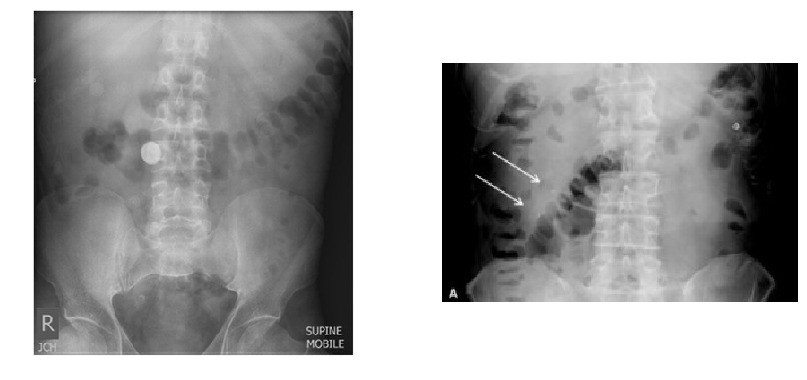

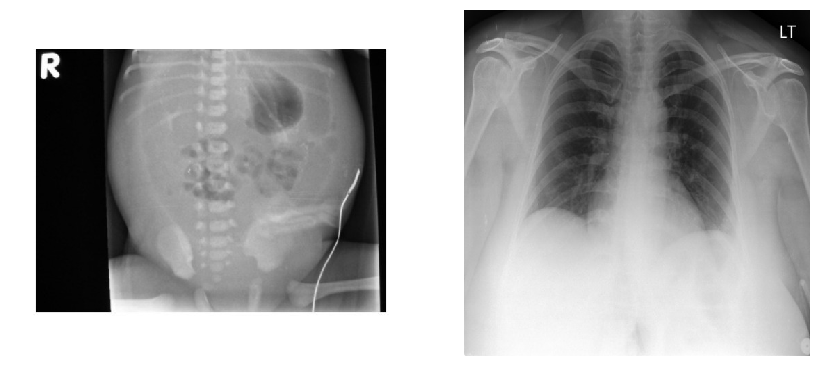

In [12]:
# visualize a few train images 
mdai.visualize.display_images(image_ids_train[:2], cols=2)
mdai.visualize.display_images(image_ids_val[:2], cols=2)

# Build Keras Model 

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [14]:
img_size = (150, 150, 3)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=img_size)

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
model_dir = os.path.join(os.getcwd(), "models/vgg16")
os.makedirs(model_dir, exist_ok=True)
print("model_dir: ",model_dir)
est = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                    model_dir=model_dir)

In [18]:
# input layer name
input_name = model.input_names[0]
input_name

'vgg16_input'

In [19]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [20]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [21]:
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [22]:
def convert(dataset, out_path, size=(150,150)):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.    
    print("\nConverting: " + out_path)
    
    image_paths = dataset.get_image_ids()
    imgs_anns_dict = dataset.imgs_anns_dict 
        
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)    
    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:        
     
        # Iterate over all the image-paths and class-labels.
        for i, image_id in enumerate(image_paths):
        
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)
            
            # Load the image-file using matplotlib's imread function.
            #img = Image.open(path)
            img = load_dicom_image(image_id, to_RGB=True)
            img = Image.fromarray(img)
            img = img.resize(size)
            img = np.array(img)
                                
            # Convert the image to raw bytes.
            img_bytes = img.tostring()
            
            ann = imgs_anns_dict[image_id][0]
            label = dataset.classes_dict[ann["labelId"]]["class_id"]
                        
            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }
            
            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)
            
            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)
            
            # Serialize the data.
            serialized = example.SerializeToString()    
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

In [23]:
def imgs_input_fn(filenames, perform_shuffle=False, repeat_count=1, batch_size=1):
    def _parse_function(serialized):
        features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }
        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.parse_single_example(serialized=serialized,
                                                 features=features)
        # Get the image as raw bytes.
        image_shape = tf.stack([150, 150, 3])
        image_raw = parsed_example['image']
        label = tf.cast(parsed_example['label'], tf.float32)
        # Decode the raw bytes so it becomes a tensor with type.
        image = tf.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, image_shape)
        image = tf.subtract(image, 116.779) # Zero-center by mean pixel
        image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), [label]
        return d
    
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

In [24]:
DATA_DIR = '/data/HelloWorld'

In [25]:
fp_tfrecords_train = os.path.join(DATA_DIR, "train.tfrecords")
fp_tfrecords_val = os.path.join(DATA_DIR, "val.tfrecords")
fp_tfrecords_test = os.path.join(DATA_DIR, "test.tfrecords")
print(fp_tfrecords_train)
print(fp_tfrecords_val)
print(fp_tfrecords_test)

/data/HelloWorld/train.tfrecords
/data/HelloWorld/val.tfrecords
/data/HelloWorld/test.tfrecords


In [26]:
convert(dataset_train, out_path=fp_tfrecords_train)
convert(dataset_val, out_path=fp_tfrecords_val)
convert(dataset_test, out_path=fp_tfrecords_test)


Converting: /data/HelloWorld/train.tfrecords
- Progress: 100.0%
Converting: /data/HelloWorld/val.tfrecords
- Progress: 100.0%
Converting: /data/HelloWorld/test.tfrecords
- Progress: 100.0%

(20, 150, 150, 3)


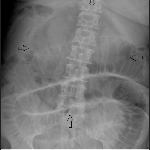

In [27]:
next_batch = imgs_input_fn(fp_tfrecords_train, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0][input_name]

print(x_d.shape)
img = tfimage.array_to_img(x_d[8])
img

In [28]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(fp_tfrecords_train,
                                                                   perform_shuffle=True,
                                                                   repeat_count=5,
                                                                   batch_size=2), 
                                    max_steps=600)

eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(fp_tfrecords_val,
                                                                 perform_shuffle=False,
                                                                 batch_size=1))

In [29]:
tf.estimator.train_and_evaluate(est, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/txia/mdai-git/mdai-client-py/notebooks/models/vgg16/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /home/txia/mdai-git/mdai-client-py/notebooks/models/vgg16/model.ckpt.
INFO:tensorflow:loss = 5.784697, step = 1
INFO:tensorflow:global_step/sec: 1.09985
INFO:tensorflow:loss = 1.1137824e-05, step = 101 (90.923 sec)
INFO:tensorflow:Saving checkpoints for 164 into /home/txia/mdai-git/mdai-client-py/notebooks/models/vgg16/model.ckpt.
INFO:tensorflow:Loss for final step: 2.8402175e-07.
INFO:t

({'acc': 1.0, 'loss': 1.0960467e-07, 'global_step': 600}, [])

In [30]:
# run on validation dataset
def predict(fp_tfrecord, dataset): 
    predict_results = est.predict(
        input_fn=lambda: imgs_input_fn(fp_tfrecord, perform_shuffle=False, batch_size=1))

    predict_logits = []
    for prediction in predict_results:
        predict_logits.append(prediction['dense_1'])

    import numpy as np
    #from skimage.transform import resize
    from PIL import Image 
    import matplotlib.pyplot as plt

    for image_id, pred in zip(dataset.get_image_ids(), predict_logits): 

        image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
        image = Image.fromarray(image)

        x = np.expand_dims(image, axis=0)    
        y = int(pred)
        
        ann = dataset.imgs_anns_dict[image_id][0]
        label = dataset.classes_dict[ann["labelId"]]["class_id"]
        
        title = 'Pred: ' + dataset.class_id_to_class_text(y) + ', Actual: ' + dataset.class_id_to_class_text(label)
        plt.figure()
        plt.title(title)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/txia/mdai-git/mdai-client-py/notebooks/models/vgg16/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


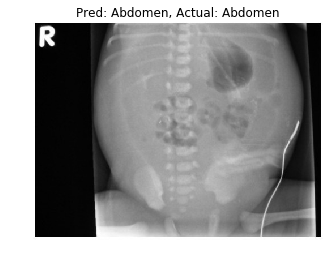

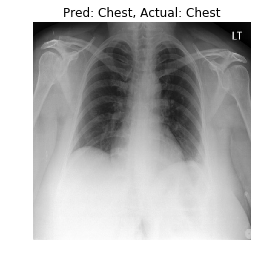

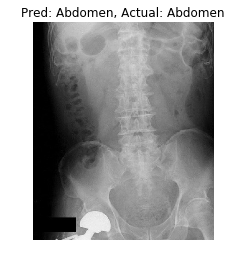

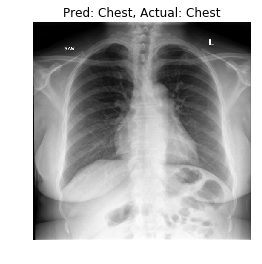

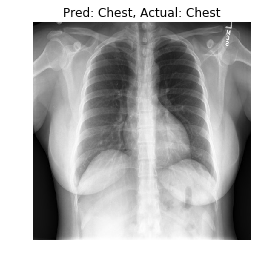

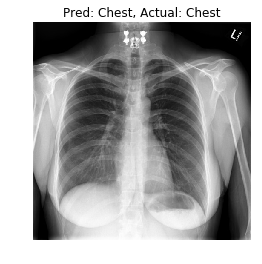

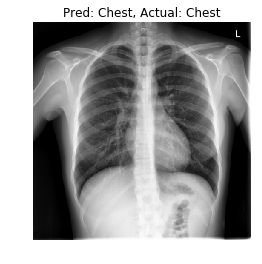

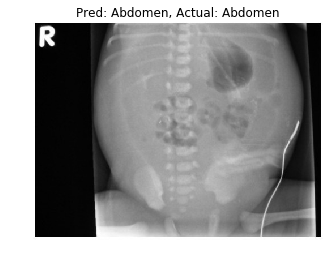

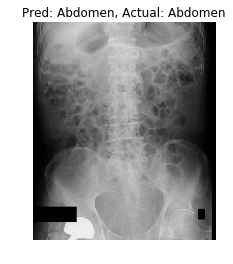

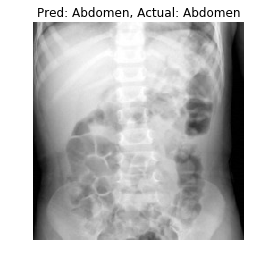

In [31]:
#predict(fp_tfrecords_train, dataset_train)
predict(fp_tfrecords_val, dataset_val)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/txia/mdai-git/mdai-client-py/notebooks/models/vgg16/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


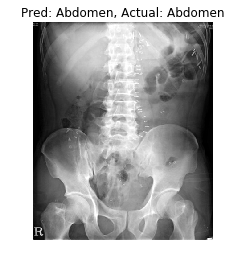

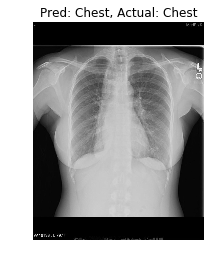

In [32]:
predict(fp_tfrecords_test, dataset_test)